
# Pipeline de Monitoramento de Motos com Visão Computacional

Este notebook mostra um **fluxo completo de dados** (simulado) para um pátio de motos, desde a **captura de imagem (visão computacional)** até a **visualização em um dashboard simples** com:
- localização das motos no pátio (grid / mini-mapa),
- estado de cada moto (em uso, parada, manutenção),
- alertas/indicadores quase em tempo real.

> **Obs.:** Como não temos o endpoint real da câmera nem o modelo treinado, vamos simular a saída de um detector de objetos (ex.: YOLO) e seguir com o restante do fluxo como se fosse produção.


In [1]:

import random
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuração padrão do matplotlib
%matplotlib inline



## 1. Captura / Detecção (Visão Computacional)

Aqui simulamos o que seria a saída de um modelo de detecção de motos em uma imagem do pátio.
Cada detecção gera:
- `moto_id`
- `bbox` (coordenadas da detecção, como se fosse o retângulo no frame)
- `confidence`
- `timestamp`

Depois traduzimos o `bbox` para uma posição no **mapa do pátio** (coordenadas normalizadas 0–1).


In [2]:

def detectar_motos_frame(num_motos=6, seed=None):
    """Simula a saída de um detector de motos em um frame de câmera."""
    if seed is not None:
        random.seed(seed)
    detections = []
    for i in range(num_motos):
        moto_id = f"M-{i+1:02d}"
        # bbox no formato (x_min, y_min, x_max, y_max) em pixels de um frame 1280x720
        x_min = random.randint(0, 900)
        y_min = random.randint(0, 400)
        w = random.randint(80, 200)
        h = random.randint(80, 200)
        x_max = min(1280, x_min + w)
        y_max = min(720, y_min + h)
        confidence = round(random.uniform(0.6, 0.98), 2)
        detections.append({
            "moto_id": moto_id,
            "bbox": (x_min, y_min, x_max, y_max),
            "confidence": confidence,
            "timestamp": datetime.now().isoformat(timespec='seconds')
        })
    return detections

detections = detectar_motos_frame()
pd.DataFrame(detections)


,moto_id,bbox,confidence,timestamp
0,M-01,"(395, 221, 512, 371)",0.89,2025-11-09T22:32:26
1,M-02,"(237, 106, 378, 192)",0.78,2025-11-09T22:32:26
2,M-03,"(408, 287, 566, 472)",0.96,2025-11-09T22:32:26
3,M-04,"(814, 209, 1009, 391)",0.82,2025-11-09T22:32:26
4,M-05,"(686, 198, 876, 294)",0.81,2025-11-09T22:32:26
5,M-06,"(72, 158, 214, 319)",0.63,2025-11-09T22:32:26



## 2. Mapeamento para o Pátio

O pátio será representado por um grid de 10x6 (60 vagas possíveis).

A conversão aqui será simples: pegamos o **centro do bbox** e normalizamos para a grade do pátio.


In [3]:

PATIO_WIDTH = 10  # colunas
PATIO_HEIGHT = 6  # linhas
FRAME_W, FRAME_H = 1280, 720

def bbox_to_patio_position(bbox):
    x_min, y_min, x_max, y_max = bbox
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    # normaliza para 0..1
    nx = cx / FRAME_W
    ny = cy / FRAME_H
    # converte para grid
    col = min(PATIO_WIDTH - 1, int(nx * PATIO_WIDTH))
    row = min(PATIO_HEIGHT - 1, int(ny * PATIO_HEIGHT))
    return row, col

def detections_to_positions(detections):
    registros = []
    for det in detections:
        row, col = bbox_to_patio_position(det["bbox"])
        registros.append({
            "moto_id": det["moto_id"],
            "row": row,
            "col": col,
            "confidence": det["confidence"],
            "timestamp": det["timestamp"]
        })
    return pd.DataFrame(registros)

posicoes_df = detections_to_positions(detections)
posicoes_df


,moto_id,row,col,confidence,timestamp
0,M-01,2,3,0.89,2025-11-09T22:32:26
1,M-02,1,2,0.78,2025-11-09T22:32:26
2,M-03,3,3,0.96,2025-11-09T22:32:26
3,M-04,2,7,0.82,2025-11-09T22:32:26
4,M-05,2,6,0.81,2025-11-09T22:32:26
5,M-06,1,1,0.63,2025-11-09T22:32:26



## 3. Estado das Motos e Alertas

Vamos simular que cada moto pode estar em um destes estados:
- **em_uso**
- **parada**
- **manutencao**

E criaremos alertas simples:
- confiança baixa
- moto fora de zona válida


In [4]:

ESTADOS_POSSIVEIS = ["em_uso", "parada", "manutencao"]

def atribuir_estado(df):
    estados = []
    for _ in range(len(df)):
        estados.append(random.choice(ESTADOS_POSSIVEIS))
    df = df.copy()
    df["estado"] = estados
    return df

def gerar_alertas(df):
    alertas = []
    for _, row in df.iterrows():
        if row["confidence"] < 0.7:
            alertas.append(f"Confiança baixa na moto {row['moto_id']} ({row['confidence']})")
        # exemplo de alerta de zona proibida: linha 0 e 1 são 'corredor'
        if row["row"] in [0, 1] and row["estado"] == "parada":
            alertas.append(f"Moto {row['moto_id']} parada em corredor (linha {row['row']}).")
    return alertas

posicoes_df = atribuir_estado(posicoes_df)
alertas = gerar_alertas(posicoes_df)

posicoes_df, alertas


(  moto_id  row  col  confidence            timestamp      estado
 0    M-01    2    3        0.89  2025-11-09T22:32:26      parada
 1    M-02    1    2        0.78  2025-11-09T22:32:26      parada
 2    M-03    3    3        0.96  2025-11-09T22:32:26      em_uso
 3    M-04    2    7        0.82  2025-11-09T22:32:26      em_uso
 4    M-05    2    6        0.81  2025-11-09T22:32:26      em_uso
 5    M-06    1    1        0.63  2025-11-09T22:32:26  manutencao,
 ['Moto M-02 parada em corredor (linha 1).',
  'Confiança baixa na moto M-06 (0.63)'])


## 4. Dashboard / Interface Final

Abaixo criamos uma visualização simples do pátio:

- Cada célula representa uma posição do pátio.
- Células preenchidas têm uma moto (mostramos o `moto_id`).
- As cores mudam conforme o **estado**:
  - verde: em_uso
  - azul: parada
  - vermelho: manutencao

Também exibimos uma tabela de motos e a lista de alertas.


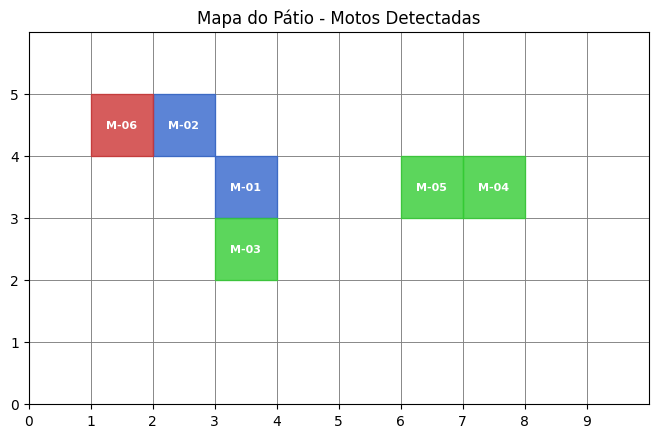

In [8]:

# mapa de cores por estado
STATE_COLORS = {
    "em_uso": (0.2, 0.8, 0.2),
    "parada": (0.2, 0.4, 0.8),
    "manutencao": (0.8, 0.2, 0.2),
}

def plot_patio(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    # desenha grid
    for r in range(PATIO_HEIGHT):
        for c in range(PATIO_WIDTH):
            ax.add_patch(plt.Rectangle((c, PATIO_HEIGHT - 1 - r), 1, 1, fill=False, edgecolor="gray", linewidth=0.5))

    # desenha motos
    for _, row in df.iterrows():
        r = row["row"]
        c = row["col"]
        color = STATE_COLORS.get(row["estado"], (0.5, 0.5, 0.5))
        ax.add_patch(plt.Rectangle((c, PATIO_HEIGHT - 1 - r), 1, 1, color=color, alpha=0.8))
        ax.text(c + 0.5, PATIO_HEIGHT - 1 - r + 0.5, row["moto_id"], ha="center", va="center", fontsize=8, color="white", weight="bold")

    ax.set_xlim(0, PATIO_WIDTH)
    ax.set_ylim(0, PATIO_HEIGHT)
    ax.set_xticks(range(PATIO_WIDTH))
    ax.set_yticks(range(PATIO_HEIGHT))
    ax.set_title("Mapa do Pátio - Motos Detectadas")
    ax.set_aspect("equal")
    plt.show()

plot_patio(posicoes_df)


In [ ]:

display(posicoes_df.sort_values("moto_id").reset_index(drop=True))

print("\nALERTAS:")
if alertas:
    for a in alertas:
        print(" -", a)
else:
    print("Nenhum alerta no momento.")
